<a href="https://colab.research.google.com/github/RichardJPovinelli/Evolutionary_Computation_Course/blob/main/moea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Multi-Objective Evolutionary Algorithms – Interactive Notebook

- See the difference between **decision space** and **objective space**.
- Implement and visualize **Pareto dominance** and a **Pareto front**.
- Explore a simple **analytic bi-objective problem**.
- Run a small **multi-objective evolutionary algorithm (MOEA)**.
- Watch an **animation** of the population converging to the Pareto front.

The notebook is designed to be **student friendly**:
- Every major block has a short explanation.
- There are **Tasks** for you to try (but the default code already runs).



## 0. Setup

Run the following cell **once** to import libraries and set plotting defaults.


In [1]:

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation
from IPython.display import HTML

# Make results reproducible
np.random.seed(42)

# Nicer plots
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["figure.dpi"] = 120

print("Setup complete ✅")


Setup complete ✅



## 1. Decision vs Objective Space – “Car” Example

We simulate a toy **car selection** problem.

- **Decision space**: abstract features of a car (e.g., engine size, weight, styling).  
- **Objectives** (to minimize):
  - $ f_1(x) $: cost  
  - $ f_2(x) $: negative speed (so lower value = higher speed)

We will:
1. Generate random “cars” in **decision space**.
2. Map them to **objective space**.
3. Plot the objective values.


In [2]:

# Number of cars (solutions)
n_cars = 500

# Decision space: 3 abstract features in [0, 1]
X = np.random.rand(n_cars, 3)

def objectives_car(x):
    # Toy car model.
    # Input: x of shape (n_solutions, 3)
    # Output: F of shape (n_solutions, 2) with [cost, negative_speed]

    # Cost increases with x0 and x1
    cost = 20000 + 15000 * x[:, 0] + 8000 * x[:, 1] + 2000 * np.random.randn(*x[:, 0].shape) * 0.02

    # Speed increases with x0, decreases with x2
    speed = 80 + 40 * x[:, 0] - 10 * x[:, 2]  + 5 * np.random.randn(*x[:, 0].shape) * 0.02

    # We minimize cost and negative speed
    f1 = cost
    f2 = -speed
    return np.vstack((f1, f2)).T

F_car = objectives_car(X)
F_car[:5]


array([[33123.84000539,   -87.79337684],
       [30319.6640894 ,  -102.37458731],
       [27745.08045005,   -76.10000888],
       [30719.94867143,   -98.56302239],
       [34226.25531471,  -111.60915541]])

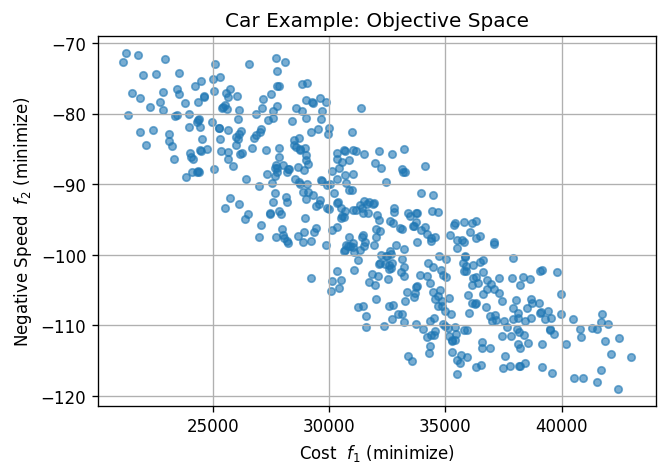

In [3]:

# Plot the car example in objective space
f1, f2 = F_car[:, 0], F_car[:, 1]

plt.scatter(f1, f2, s=20, alpha=0.6)  # s is point size in points^2 (area)
plt.xlabel("Cost  $f_1$ (minimize)")
plt.ylabel("Negative Speed  $f_2$ (minimize)")
plt.title("Car Example: Objective Space")
plt.grid(True)
plt.show()



### ✏️ Task 1

- In the `objectives_car` function, change how `cost` and `speed` are computed.  
- For example, make cost **decrease** with one of the features, or add a new nonlinear term.  
- Re-run the previous cells and observe how the cloud of points in objective space changes.



## 2. Pareto Dominance and Pareto Front

For **minimization** problems, solution **a dominates b** if:

- `a` is **no worse** than `b` in *all* objectives, and  
- `a` is **strictly better** in *at least one* objective.

We will:

1. Implement a `dominates(a, b)` function.
2. Implement `pareto_front(F)` to return all **non-dominated** points.
3. Visualize the Pareto front in objective space.


In [4]:

def dominates(a, b):
    # Return True if a dominates b (for minimization).
    # a, b: 1D arrays of objective values with the same length.
    return np.all(a <= b) and np.any(a < b)


def pareto_front(F):
    # Compute indices of non-dominated points in F.
    # F: array of shape (n_points, n_objectives)
    n_points = F.shape[0]
    is_dominated = np.zeros(n_points, dtype=bool)

    for i in range(n_points):
        if is_dominated[i]:
            continue
        for j in range(n_points):
            if i == j:
                continue
            if dominates(F[j], F[i]):
                is_dominated[i] = True
                break

    return np.where(~is_dominated)[0]

# Compute the Pareto front for the car example
pf_idx = pareto_front(F_car)
print("Number of Pareto-optimal cars:", len(pf_idx))
pf_idx[:10]


Number of Pareto-optimal cars: 24


array([ 19,  23,  68,  69, 111, 123, 146, 171, 240, 270])

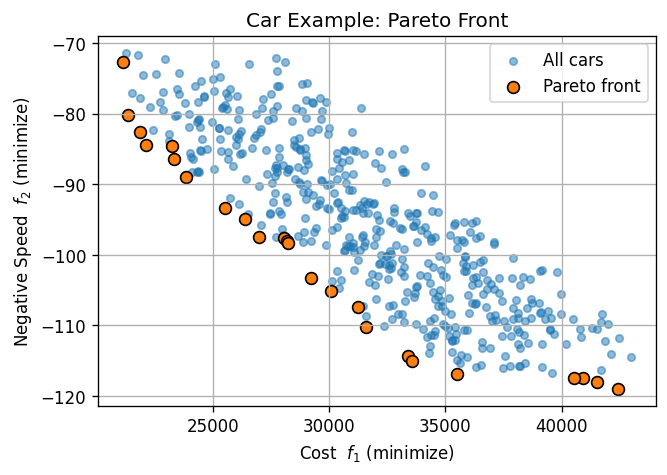

In [5]:

# Visualize Pareto front in objective space
plt.scatter(f1, f2, s=20, alpha=0.5, label="All cars")
plt.scatter(f1[pf_idx], f2[pf_idx], edgecolor="k", s=50, label="Pareto front")
plt.xlabel("Cost  $f_1$ (minimize)")
plt.ylabel("Negative Speed  $f_2$ (minimize)")
plt.title("Car Example: Pareto Front")
plt.legend()
plt.grid(True)
plt.show()



### ✏️ Task 2

- Pick two points on the plot and check **by hand** if one dominates the other.  
- Compare your reasoning with what `dominates(a, b)` returns.



## 3. Analytic Bi-Objective Example

Now we study a very simple problem with a **continuous decision variable** $ x \in [0, 2] $:

$
f_1(x) = x^2, \quad f_2(x) = (x - 2)^2
$

Both objectives are minimized.

- For different values of $ x $, we get different trade-offs between $ f_1 $ and $ f_2 $.
- Many of these points are **Pareto-optimal**.

We will:
1. Plot $ f_1(x) $ and $ f_2(x) $ vs. $ x $ (decision space view).
2. Plot $ f_1 $ vs. $ f_2 $ (objective space view).
3. Highlight the non-dominated set.


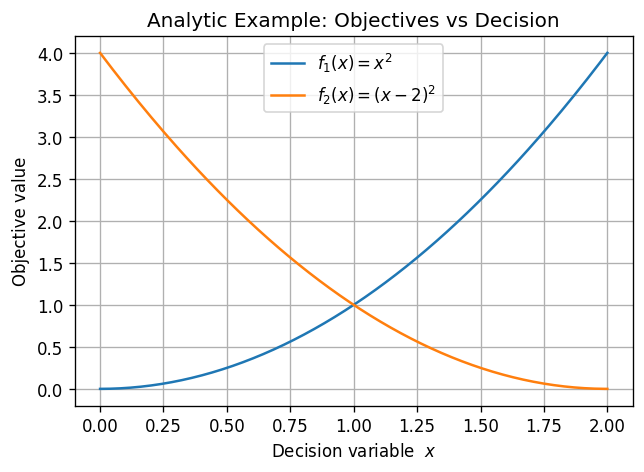

In [6]:

def f_analytical(x):
    # Compute (f1, f2) for the analytic example.
    # x: 1D array of decision values
    # Returns: array of shape (len(x), 2)
    f1 = x**2
    f2 = (x - 2)**2
    return np.vstack((f1, f2)).T

x_grid = np.linspace(0, 2, 200)
F_grid = f_analytical(x_grid)

# Plot objectives vs decision variable x
plt.plot(x_grid, F_grid[:, 0], label=r"$f_1(x) = x^2$")
plt.plot(x_grid, F_grid[:, 1], label=r"$f_2(x) = (x - 2)^2$")
plt.xlabel("Decision variable  $x$")
plt.ylabel("Objective value")
plt.title("Analytic Example: Objectives vs Decision")
plt.legend()
plt.grid(True)
plt.show()


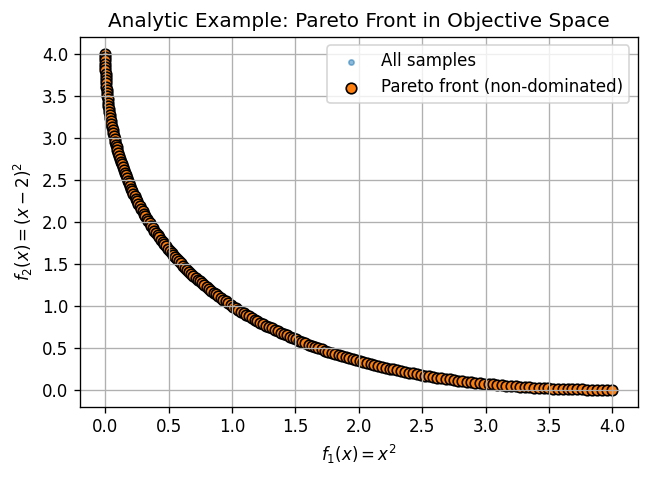

In [7]:

# Compute and plot Pareto front in objective space
pf_idx_grid = pareto_front(F_grid)

plt.scatter(F_grid[:, 0], F_grid[:, 1], s=10, alpha=0.5, label="All samples")
plt.scatter(F_grid[pf_idx_grid, 0], F_grid[pf_idx_grid, 1],
            edgecolor="k", s=40, label="Pareto front (non-dominated)")
plt.xlabel(r"$f_1(x) = x^2$")
plt.ylabel(r"$f_2(x) = (x - 2)^2$")
plt.title("Analytic Example: Pareto Front in Objective Space")
plt.legend()
plt.grid(True)
plt.show()



### ✏️ Task 3

- Change the objective functions to something more **nonlinear** (e.g., sines/cosines or piecewise definitions).  
- Re-run the cells and see how the shape of the Pareto front changes.



## 4. A Simple MOEA on a ZDT1-like Problem

We now move to a standard multi-objective test problem (ZDT1-like). Search to find out what the ZDT problems are.

- Decision variables: $ x \in [0, 1]^{10} $
- Objectives:
  - $ f_1(x) = x_0 $
  - $ g(x) = 1 + 9 \cdot \frac{1}{n-1} \sum_{i=1}^{n-1} x_i $
  - $ f_2(x) = g(x) \left(1 - \sqrt{\frac{f_1(x)}{g(x)}}\right) $

We will:
1. Define the problem.
2. Implement a **simple NSGA-II–style** MOEA:
   - Non-dominated sorting (ranks)
   - Crowding distance (diversity)
   - Crossover + mutation
3. Watch an **animation** of the population in objective space over generations.


In [8]:

# Problem definition: ZDT1-like

n_vars = 10  # number of decision variables

def zdt1(x):
    # ZDT1-like test problem.
    # x: array of shape (..., n_vars)
    # Returns: array of shape (..., 2) with objectives [f1, f2]
    x = np.atleast_2d(x)
    f1 = x[:, 0]
    g = 1 + 9 * np.sum(x[:, 1:], axis=1) / (n_vars - 1)
    f2 = g * (1 - np.sqrt(f1 / g))
    return np.vstack((f1, f2)).T


In [9]:

def non_dominated_sort(F):
    # Perform non-dominated sorting.
    # Returns:
    #   ranks: array of rank (0 = best front) for each solution
    #   fronts: list of lists, each inner list is indices of one front
    n = F.shape[0]
    S = [[] for _ in range(n)]  # S[p] = solutions dominated by p
    n_dom = np.zeros(n, dtype=int)  # number of solutions that dominate p
    fronts = [[]]

    for p in range(n):
        for q in range(n):
            if dominates(F[p], F[q]):
                S[p].append(q)
            elif dominates(F[q], F[p]):
                n_dom[p] += 1
        if n_dom[p] == 0:
            fronts[0].append(p)

    i = 0
    while fronts[i]:
        next_front = []
        for p in fronts[i]:
            for q in S[p]:
                n_dom[q] -= 1
                if n_dom[q] == 0:
                    next_front.append(q)
        i += 1
        fronts.append(next_front)
    fronts.pop()  # remove last empty front

    ranks = np.empty(n, dtype=int)
    for i, front in enumerate(fronts):
        for p in front:
            ranks[p] = i

    return ranks, fronts


def crowding_distance(F, front_indices):
    # Compute crowding distance for a single front.
    # front_indices: list of indices of solutions in this front.
    # Returns: array of distances aligned with front_indices.
    if len(front_indices) == 0:
        return np.array([])

    F_front = F[front_indices]
    n = len(front_indices)
    distances = np.zeros(n)
    n_objs = F.shape[1]

    for m in range(n_objs):
        order = np.argsort(F_front[:, m])
        sorted_vals = F_front[order, m]
        distances[order[0]] = np.inf
        distances[order[-1]] = np.inf
        denom = sorted_vals[-1] - sorted_vals[0]
        if denom == 0:
            continue
        for i in range(1, n - 1):
            distances[order[i]] += (sorted_vals[i + 1] - sorted_vals[i - 1]) / denom

    return distances


In [10]:

def crossover(p1, p2, eta=10.0, p_c=0.9):
    # Simpler SBX-like crossover (real-coded).
    # Returns two children.
    if np.random.rand() > p_c:
        return p1.copy(), p2.copy()

    c1, c2 = p1.copy(), p2.copy()
    for i in range(len(p1)):
        u = np.random.rand()
        if u <= 0.5:
            beta = (2 * u) ** (1.0 / (eta + 1))
        else:
            beta = (1 / (2 * (1 - u))) ** (1.0 / (eta + 1))
        x1, x2 = p1[i], p2[i]
        c1[i] = 0.5 * ((1 + beta) * x1 + (1 - beta) * x2)
        c2[i] = 0.5 * ((1 - beta) * x1 + (1 + beta) * x2)
    return c1, c2


def mutate(x, p_m=0.1, sigma=0.1):
    # Gaussian mutation with clipping to [0, 1].
    y = x.copy()
    for i in range(len(y)):
        if np.random.rand() < p_m:
            y[i] = y[i] + sigma * np.random.randn()
    return np.clip(y, 0.0, 1.0)


In [11]:

# MOEA main loop
pop_size = 100
n_generations = 100

# Initialize random population in [0, 1]^n_vars
pop = np.random.rand(pop_size, n_vars)

# History of objective values over generations (for animation)
history = []

for gen in range(n_generations):
    F = zdt1(pop)
    history.append(F)  # store for animation

    ranks, fronts = non_dominated_sort(F)

    # Generate offspring
    offspring = []
    while len(offspring) < pop_size:
        # Select parents uniformly at random (simple; can replace with tournament selection)
        i, j = np.random.randint(pop_size), np.random.randint(pop_size)
        p1, p2 = pop[i], pop[j]

        c1, c2 = crossover(p1, p2)
        c1 = mutate(c1)
        c2 = mutate(c2)

        offspring.append(c1)
        if len(offspring) < pop_size:
            offspring.append(c2)

    offspring = np.array(offspring)
    F_off = zdt1(offspring)

    # Combine parents and offspring (elitism)
    combined = np.vstack((pop, offspring))
    F_combined = np.vstack((F, F_off))

    ranks_combined, fronts_combined = non_dominated_sort(F_combined)

    # NSGA-II style selection: fill next generation front by front
    new_pop_indices = []
    for front in fronts_combined:
        if len(new_pop_indices) + len(front) <= pop_size:
            new_pop_indices.extend(front)
        else:
            # Use crowding distance to select within this last front
            cd = crowding_distance(F_combined, front)
            order = np.argsort(-cd)  # sort descending by distance
            remaining = pop_size - len(new_pop_indices)
            chosen = [front[i] for i in order[:remaining]]
            new_pop_indices.extend(chosen)
            break

    pop = combined[new_pop_indices]
    print(f"Generation {gen+1}/{n_generations} complete.")

# Final objectives
F_final = zdt1(pop)
print("MOEA run complete ✅")


Generation 1/100 complete.
Generation 2/100 complete.
Generation 3/100 complete.
Generation 4/100 complete.
Generation 5/100 complete.
Generation 6/100 complete.
Generation 7/100 complete.
Generation 8/100 complete.
Generation 9/100 complete.
Generation 10/100 complete.
Generation 11/100 complete.
Generation 12/100 complete.
Generation 13/100 complete.
Generation 14/100 complete.
Generation 15/100 complete.
Generation 16/100 complete.
Generation 17/100 complete.
Generation 18/100 complete.
Generation 19/100 complete.
Generation 20/100 complete.
Generation 21/100 complete.
Generation 22/100 complete.
Generation 23/100 complete.
Generation 24/100 complete.
Generation 25/100 complete.
Generation 26/100 complete.
Generation 27/100 complete.
Generation 28/100 complete.
Generation 29/100 complete.
Generation 30/100 complete.
Generation 31/100 complete.
Generation 32/100 complete.
Generation 33/100 complete.
Generation 34/100 complete.
Generation 35/100 complete.
Generation 36/100 complete.
G


## 5. Animation: Population Converging to the Pareto Front

Now we use `matplotlib.animation.FuncAnimation` to show:

- Early generations: scattered points far from the Pareto front.
- Later generations: points concentrated near the true front.

We also plot the **true Pareto front** for ZDT1 (continuous curve).


In [12]:

# Prepare true ZDT1 Pareto front for reference
f1_true = np.linspace(0, 1, 200)
f2_true = 1 - np.sqrt(f1_true)

# Set up the figure for animation
fig, ax = plt.subplots()

# Initial scatter (will be updated)
scat = ax.scatter(history[0][:, 0], history[0][:, 1], s=15, alpha=0.7)

# Plot the true front
ax.plot(f1_true, f2_true, lw=2)
front_line = ax.lines[-1]  # last line is the front

ax.set_xlim(0, 1.1)
ax.set_ylim(0, 1.1)
ax.set_xlabel("$f_1$")
ax.set_ylabel("$f_2$")
title = ax.set_title("Generation 0")
ax.grid(True)


def update(frame):
    # Update function for each frame of the animation.
    F_frame = history[frame]
    scat.set_offsets(F_frame)
    title.set_text(f"Generation {frame}")
    return scat, title


ani = animation.FuncAnimation(
    fig,
    update,
    frames=len(history),
    interval=200,  # milliseconds between frames
    blit=False,
    repeat=True
)

plt.close(fig)  # Prevent duplicate static plot

# Display animation as JS HTML (no extra dependencies needed)
HTML(ani.to_jshtml())



### ✏️ Task 4

- Change `pop_size`, `n_generations`, or mutation parameters in the MOEA loop.  
- Re-run the MOEA cell and the animation cell.  
- Observe how this affects:
  - **Speed of convergence** to the front.
  - **Diversity** along the front.



## 6. Wrap-Up and Extensions

You have:

- Implemented **Pareto dominance** and found **Pareto fronts**.
- Explored both **toy** and **analytical** multi-objective problems.
- Run and visualized a small **multi-objective evolutionary algorithm**.
- Watched an **animation** of convergence and diversity in objective space.

### Extensions

- Replace ZDT1 with another test problem (e.g., ZDT2, ZDT3) or a **real design problem**.  
- Add a **constraint** and implement constraint handling (e.g., penalty functions).  
- Compute a simple **convergence metric**, such as the average distance from the true front.
